# Quickstart

PyTorch has two primitives to work with data: 
- torch.utils.data.DataLoader -> DataLoader wraps an iterable around the Dataset.
- torch.utils.data.Dataset -> Dataset stores the samples and their corresponding labels 

## Step 1: Import Libraries

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Import Data

In [4]:
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
BATCH_SIZE = 64

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

for batch, (X, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    print(f"Batch {batch + 1} - X shape: {X.shape}, y shape: {y.shape}")
    break

  0%|          | 0/938 [00:00<?, ?it/s]

Batch 1 - X shape: torch.Size([64, 1, 28, 28]), y shape: torch.Size([64])


## Step 3:Visualize Data using matplolib

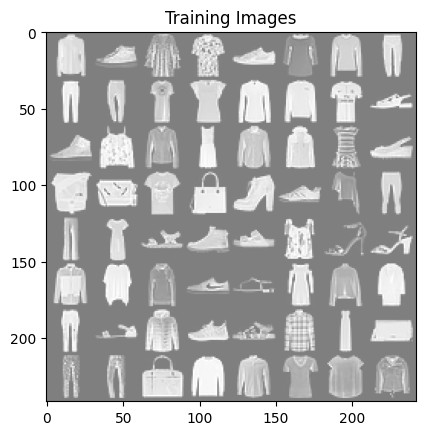

In [11]:
import torchvision

def imshow(img, title=None):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images), title="Training Images")

## Step 4: Create Model

In [21]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits
    
model = FashionMNISTModel().to(device)
print(model)
        

FashionMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Step 5: Setting up Parameters

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

## Step 6: Traning Model

In [23]:
def train(dataloader, model, loss_fn, optimizer, epochs=5):
    model.train()
    size = len(dataloader.dataset)
    for epoch in range(epochs):
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        print(f"Epoch {epoch + 1} completed.")

In [ ]:
train(train_dataloader, model, loss_fn, optimizer, 10)

## Step 7: Test Model

In [25]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.323725 



## Step 8: Saving Model

In [28]:
torch.save(model.state_dict(), "saved_models/model.pth")
print("Saved PyTorch Model State to saved_models/model.pth")

Saved PyTorch Model State to saved_models/model.pth


## Step 9: Loading Model

In [30]:
model = FashionMNISTModel().to(device)
model.load_state_dict(torch.load("saved_models/model.pth", weights_only=True))

<All keys matched successfully>

## Step 10: Evaluating Model

In [31]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
